# Example 2: How does global warming will affect urban climates?

In [1]:
from pyclmuapp import usp_clmu
import matplotlib.pyplot as plt

Here we use the `RUN_TYPE= "branch"` to avoid the repeated spinup phases.

The case (`usp_spinup`) is run for 10 years to spinup the model.

How to get `usp_spinup` ?

```python
usp_spinup = usp.run(
            case_name = "usp_spinup", 
            SURF="surfdata.nc",
            FORCING="forcing.nc",
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "10",
            RUN_TYPE= "coldstart",
        )
usp_spinup
```

In [2]:
%%time
# initialize
usp = usp_clmu()

# create a new case amd run it
usp_or = usp.run(
            case_name = "example2", 
            SURF="surfdata.nc",
            FORCING="forcing.nc",
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
        )
usp_or

Copying the file forcing.nc to the /Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/workdir/inputfolder/usp
CPU times: user 1.12 s, sys: 375 ms, total: 1.5 s
Wall time: 2min 42s


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/workdir/outputfolder/lnd/hist/example2_clm0_2024-11-23_15-21-24_clm.nc']



### 2 modify the forcing data


using `action={"Tair": 1}`, `mode="add"`

Here, we can use the same case_name `example2`, so that we will not need to build the case (compile CTSM code) again. 

run time will be save

In [3]:
%%time

# we have run a simulation using the `usp` object, 
# the forcing data path is stored in the `usp.usr_forcing_file` attribute
# the surface data path is stored in the `usp.surfdata` attribute
# we can modify the forcing data by calling the `usp.modify_forcing` method 
# and run the simulation again using the `usp.run` method

# if there is no forcing data path provided or have not run a simulation using the `usp` object,
# check the forcing, by calling `usp.check_forcing(usr_forcing="forcing.nc")` method

usp.modify_forcing(action={"Tair": 1}, # dict
                   mode="add", # optional; the default is "replace"
                   forcing_name="forcing_replaced.nc") # optional; the default is "forcing.nc" provided by pyclmuapp
usp_warming = usp.run(
            case_name = "example2", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
        )
usp.modify_forcing(action={"Tair": -1},# dict
                   mode="add", # optional; the default is "replace"
                   forcing_name="forcing_replaced.nc") # optional; the default is "forcing.nc" provided by pyclmuapp
usp_warming

CPU times: user 650 ms, sys: 125 ms, total: 776 ms
Wall time: 1min 33s


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/workdir/outputfolder/lnd/hist/example2_clm0_2024-11-23_15-22-57_clm.nc']

In [4]:
ds_or_usp = usp.nc_view(usp_or[0])
ds_warming_usp = usp.nc_view(usp_warming[0])

### 3 Plotting


Note: ploting with time will need the `nc-time-axis` package, which can be installed by `pip install nc-time-axis` or `conda install nc-time-axis`

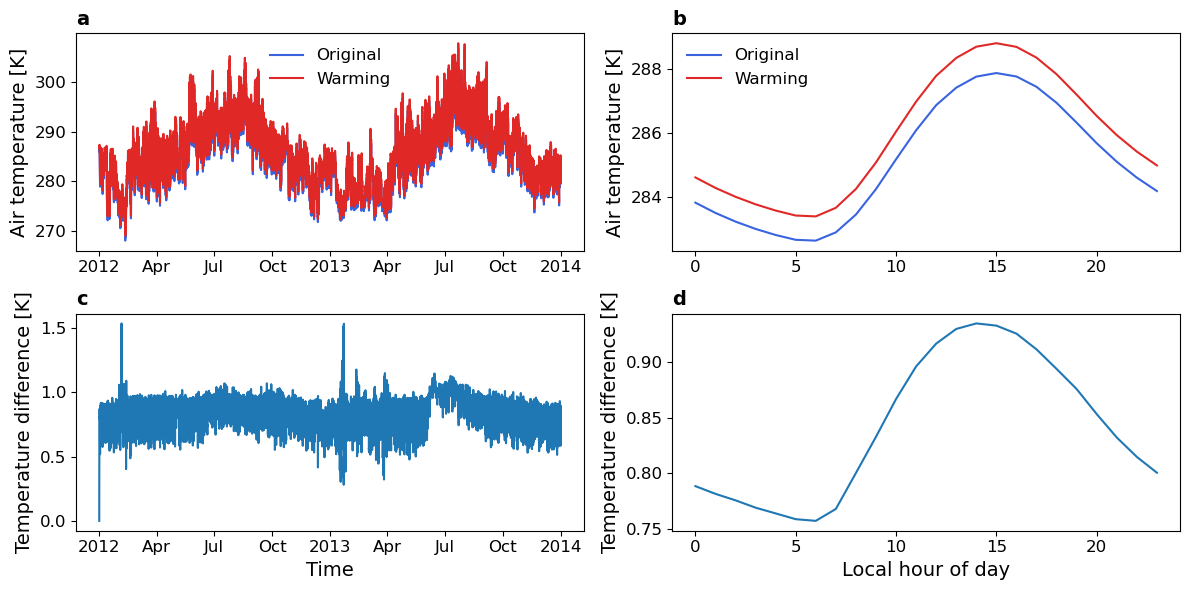

In [5]:
fig = plt.figure(figsize=(12, 6))

# plot the original and warming surface temperature
ax = fig.add_subplot(2, 2, 1)
ds_or_usp['TSA'].isel(gridcell=0).plot(ax=ax, label="Original", color='#3964DF')
ds_warming_usp['TSA'].isel(gridcell=0).plot(ax=ax, label="Warming", color='#E02927')
ax.legend(frameon=False, fontsize=12)

# plot the original and warming surface temperature hourly
ax = fig.add_subplot(2, 2, 2)
def plot_hourly(ds, ax, title, color):
    ds['TSA'].groupby('time.hour').mean().plot(ax=ax, label=title, color=color)

plot_hourly(ds_or_usp, ax, "Original", '#3964DF')
plot_hourly(ds_warming_usp, ax, "Warming", '#E02927')
ax.legend(frameon=False, fontsize=12)

# plot the residual
ax = fig.add_subplot(2, 2, 3)
dd = (ds_warming_usp['TSA']-ds_or_usp['TSA']).isel(gridcell=0).plot()

# plot the residual hourly
ax = fig.add_subplot(2, 2, 4)
dd = (ds_warming_usp['TSA']-ds_or_usp['TSA']).isel(gridcell=0).groupby('time.hour')
mean = dd.mean('time')
var = dd.var('time')
mean.plot(ax=ax)

# set labels
xlabels = ['', '', 'Time', 'Local hour of day']
ylabels = ['Air temperature [K]', 'Air temperature [K]', 'Temperature difference [K]', 'Temperature difference [K]']
titles = ['a', 'b', 'c', 'd']
for ax in fig.axes:
    ax.set_xlabel(xlabels.pop(0), fontsize=14)
    ax.set_ylabel(ylabels.pop(0), fontsize=14)
    ax.set_title(titles.pop(0), loc='left', fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('figs/example2_usp.pdf', dpi=300)
plt.show()

**clean up the case files**

In [6]:
usp.case_clean(case_name="example2")

# when you using ups.run(crun_type='usp-exec') --> see warmup section
# the case files in ./workdir/ouptutfolder/your_case, ./workdir/logfolder/your_case, 
# and ./workdir/inputfoler/usp will be removed.

# when you using ups.run(crun_type='run') or ups.run(), the default crun_type is 'run'
# only ./workdir/inputfoler/usp will be removed.